In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.datasets as datasets
import copy
%matplotlib inline

## Loading the dataset

In [4]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

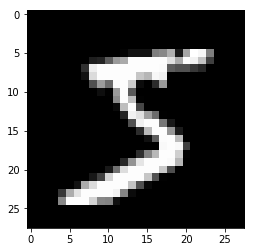

In [5]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')

In [6]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 64#300
EPOCHS = 10

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label)

## Training a linear model

In [75]:
linear_regression = tnn.LinearLayer(input_size, output_size, optimizer=tnn.Adam())

accuracy_list = []
for epoch in range(EPOCHS):
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = linear_regression.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = linear_regression.backward(dy)

        linear_regression.update()
        
        if index % 100 == 0:
            
            print('\nTRAIN',index, '-> ', loss)
            yout = linear_regression.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = linear_regression.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))            


TRAIN 0 ->  6.450176223181375
EPOCH =  0 accuracy =  19.69666666666667
11818 / 60000
   TEST   accuracy =  20.01
2001 / 10000

TRAIN 100 ->  5.774559827901976
EPOCH =  0 accuracy =  86.31666666666666
51790 / 60000
   TEST   accuracy =  87.22
8722 / 10000

TRAIN 200 ->  5.774778735032907
EPOCH =  0 accuracy =  87.33999999999999
52404 / 60000
   TEST   accuracy =  87.57000000000001
8757 / 10000

TRAIN 300 ->  5.7679746081114045
EPOCH =  0 accuracy =  90.005
54003 / 60000
   TEST   accuracy =  89.75999999999999
8976 / 10000

TRAIN 400 ->  5.811193166267586
EPOCH =  0 accuracy =  88.45166666666667
53071 / 60000
   TEST   accuracy =  88.46000000000001
8846 / 10000

TRAIN 500 ->  5.775163123665431
EPOCH =  0 accuracy =  87.60666666666667
52564 / 60000
   TEST   accuracy =  88.01
8801 / 10000

TRAIN 600 ->  5.795382384612699
EPOCH =  0 accuracy =  86.015
51609 / 60000
   TEST   accuracy =  85.7
8570 / 10000

TRAIN 700 ->  5.809263302384388
EPOCH =  0 accuracy =  87.795
52677 / 60000
   TEST 


TRAIN 500 ->  5.80725145970295
EPOCH =  6 accuracy =  87.84833333333333
52709 / 60000
   TEST   accuracy =  87.32
8732 / 10000

TRAIN 600 ->  5.758058390487008
EPOCH =  6 accuracy =  88.61166666666666
53167 / 60000
   TEST   accuracy =  87.53999999999999
8754 / 10000

TRAIN 700 ->  5.820345400046577
EPOCH =  6 accuracy =  90.32
54192 / 60000
   TEST   accuracy =  90.09
9009 / 10000

TRAIN 800 ->  5.888612235035079
EPOCH =  6 accuracy =  89.19
53514 / 60000
   TEST   accuracy =  88.52
8852 / 10000

TRAIN 900 ->  5.836296382963571
EPOCH =  6 accuracy =  88.99666666666667
53398 / 60000
   TEST   accuracy =  88.73
8873 / 10000

TRAIN 0 ->  5.769917443767387
EPOCH =  7 accuracy =  85.97166666666666
51583 / 60000
   TEST   accuracy =  85.74000000000001
8574 / 10000

TRAIN 100 ->  5.69690362189184
EPOCH =  7 accuracy =  88.68166666666667
53209 / 60000
   TEST   accuracy =  88.72
8872 / 10000

TRAIN 200 ->  5.730114722357694
EPOCH =  7 accuracy =  88.78333333333333
53270 / 60000
   TEST   acc

## Creating a Soft Decision Tree classes

In [12]:
class LeafNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.fc = tnn.NonLinearLayer(input_dim, output_dim, optimizer=tnn.Adam(learning_rate))
        self.fc_out = None
        self.prob = None
        self.del_outputs = None
        self.del_prob = None
        
    def forward(self, inputs, prob):
        self.prob = prob
        self.fc_out = self.fc.forward(inputs)
        return self.fc_out * prob
    
    def backward(self, del_outputs):
        self.del_outputs = del_outputs
        self.del_prob = np.mean(self.fc_out*del_outputs, axis=1, keepdims=True)
        del_inputs = self.fc.backward(del_outputs*self.prob)
        return del_inputs, self.del_prob
    
    def update(self):
        self.fc.update()
        

class InnerNode(object):
    
    def __init__(self, input_dim, output_dim, learning_rate=0.0001):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.fc = tnn.NonLinearLayer(input_dim, 1, activation=tnn.Sigmoid(), optimizer=tnn.Adam(learning_rate))
        self.probs = None
        self.left = None
        self.right = None
        
        self.prob = None
        self.prob_left = None
        self.prob_right = None
        return
    
#     def forward(self, inputs):
#         probs = self.fc.forward(inputs)
#         return probs
    
    def create_child(self, depth):
        if depth > 1:
            self.left = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = InnerNode(self.input_dim, self.output_dim, self.learning_rate)
            self.left.create_child(depth-1)
            self.right.create_child(depth-1)
        else:
            self.left = LeafNode(self.input_dim, self.output_dim, self.learning_rate)
            self.right = LeafNode(self.input_dim, self.output_dim, self.learning_rate)

    
    def forward(self, inputs, prob=1):
        self.prob = prob
        self.probs = self.fc.forward(inputs)
        self.prob_left = self.probs*self.prob
        self.prob_right = (1-self.probs)*self.prob        
        
        out_left = self.left.forward(inputs, self.prob_left)
        out_right = self.right.forward(inputs, self.prob_right)
        
        output = out_left + out_right
        return output
    
    def backward(self, del_outputs):
#         del_out_left = del_output*prob_left
#         del_out_right = del_output*prob_right
#         del_inp_left, del_prob_left = self.left.backward(del_out_left)
#         del_inp_right, del_prob_right = self.right.backward(del_out_right)

        del_inp_left, del_prob_left = self.left.backward(del_outputs)
        del_inp_right, del_prob_right = self.right.backward(del_outputs)
        
        del_probs = (del_prob_left - del_prob_right)*self.prob
        del_inp_probs = self.fc.backward(del_probs)
        
        del_prob = self.probs*del_prob_left + (1-self.probs)*del_prob_right
        del_inputs = del_inp_left + del_inp_right + del_inp_probs
        
        return del_inputs, del_prob
        
#         del_out = del_out_left*prob_left + del_out_right*prob_right
#         del_probs = 
        
    def update(self):
        self.fc.update()
        self.left.update()
        self.right.update()

In [13]:
sdt = InnerNode(input_size, output_size)
sdt.create_child(2)
sdt.left

In [14]:
target = train_label[:10]
output = sdt.forward(train_data[:10], prob=1)
# np.argmax(output, axis=1)
# np.argmax(target, axis=1)
loss = tnn.SoftmaxCrossEntropy().loss(output, target)
del_output = tnn.SoftmaxCrossEntropy().del_loss(output, target)

del_input, del_prob = sdt.backward(del_output)
sdt.update()

### doing this in a loop

In [15]:
tree_depth = 3
sdt = InnerNode(input_size, output_size)
sdt.create_child(tree_depth)

In [16]:
accuracy_list = []
for epoch in range(EPOCHS):
    for index in range(train_size // batch_size):
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx, dprob = sdt.backward(dy)

        sdt.update()
        
        if index % 100 == 0:
            
            print('\nTRAIN',index, '-> ', loss)
            yout = sdt.forward(train_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(train_label_)).sum()

            accuracy = correct / len(train_label_) * 100.
            print('EPOCH = ',epoch,'accuracy = ', accuracy)
            print(correct, '/', len(train_label_))
            
            yout = sdt.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout)
            correct = (outputs == np.array(test_label_)).sum()

            accuracy = correct / len(test_label_) * 100.
            print('   TEST  ','accuracy = ', accuracy)
            print(correct, '/', len(test_label_))            


TRAIN 0 ->  6.447160986790308
EPOCH =  0 accuracy =  13.79
8274 / 60000
   TEST   accuracy =  13.73
1373 / 10000

TRAIN 100 ->  6.216382369780431
EPOCH =  0 accuracy =  61.57333333333334
36944 / 60000
   TEST   accuracy =  61.5
6150 / 10000

TRAIN 200 ->  6.16115673566288
EPOCH =  0 accuracy =  76.64666666666666
45988 / 60000
   TEST   accuracy =  76.75
7675 / 10000

TRAIN 300 ->  5.992506037710641
EPOCH =  0 accuracy =  81.985
49191 / 60000
   TEST   accuracy =  82.5
8250 / 10000

TRAIN 400 ->  5.995184723622408
EPOCH =  0 accuracy =  84.63833333333334
50783 / 60000
   TEST   accuracy =  85.2
8520 / 10000

TRAIN 500 ->  5.958755016902094
EPOCH =  0 accuracy =  85.81833333333333
51491 / 60000
   TEST   accuracy =  86.39
8639 / 10000

TRAIN 600 ->  5.929378456817178
EPOCH =  0 accuracy =  86.945
52167 / 60000
   TEST   accuracy =  87.61
8761 / 10000

TRAIN 700 ->  5.9911431221488805
EPOCH =  0 accuracy =  87.63833333333334
52583 / 60000
   TEST   accuracy =  88.02
8802 / 10000

TRAIN 8

EPOCH =  6 accuracy =  95.525
57315 / 60000
   TEST   accuracy =  95.24000000000001
9524 / 10000

TRAIN 600 ->  5.712656008070924
EPOCH =  6 accuracy =  95.50833333333333
57305 / 60000
   TEST   accuracy =  95.16
9516 / 10000

TRAIN 700 ->  5.75575464855277
EPOCH =  6 accuracy =  95.65333333333334
57392 / 60000
   TEST   accuracy =  95.16
9516 / 10000

TRAIN 800 ->  5.719616780212816
EPOCH =  6 accuracy =  95.645
57387 / 60000
   TEST   accuracy =  95.3
9530 / 10000

TRAIN 900 ->  5.749004140857492
EPOCH =  6 accuracy =  95.68666666666667
57412 / 60000
   TEST   accuracy =  95.39999999999999
9540 / 10000

TRAIN 0 ->  5.719000581765647
EPOCH =  7 accuracy =  95.625
57375 / 60000
   TEST   accuracy =  95.33
9533 / 10000

TRAIN 100 ->  5.697019389460612
EPOCH =  7 accuracy =  95.71333333333332
57428 / 60000
   TEST   accuracy =  95.35
9535 / 10000

TRAIN 200 ->  5.719717640712739
EPOCH =  7 accuracy =  95.73
57438 / 60000
   TEST   accuracy =  95.21
9521 / 10000

TRAIN 300 ->  5.725695906